# Set up

In [2]:
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

from pathlib import Path
import re
import pickle
import seaborn as sns

# Read&Edit Data

In [6]:
df = pd.read_csv("../PlotData/MVGP_21_result.csv")


def parse_list_safe(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return []

df["estimated_params_list"] = df["estimated_params"].apply(parse_list_safe)


params_df = df["estimated_params_list"].apply(pd.Series)


In [7]:
params_df.to_csv("Result/PE_result/PE_X_result.csv", index=False, header=False)

In [2]:
df = pd.read_csv("Result/MVGP_X_1_1_result.csv")

def parse_np_float_list(s):
    if pd.isna(s):
        return []
    s = str(s)

    s = re.sub(r'np\.float32\(', '', s)
    s = s.replace(')', '')

    try:
        out = ast.literal_eval(s)
    except Exception:
        out = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', s)
    return [float(x) for x in out]


params_list = df["estimated_params"].apply(parse_np_float_list)
params_df = params_list.apply(pd.Series)


In [3]:
params_df.to_csv("Result/PE_result/PE_X_1_1_result.csv", index=False, header=False)

# Compare with the global version

In [10]:
X_test = pd.read_csv('../Data/X_test.csv', header=None, delimiter=',').values
# X_1_1 = pd.read_csv('X_1_1.csv', header=None, delimiter=',').values
# X_1_5 = pd.read_csv('X_1_5.csv', header=None, delimiter=',').values
X_2 = pd.read_csv('X_2.csv', header=None, delimiter=',').values

PE_X_test = pd.read_csv('Result/PE_result//PE_X_result.csv', header=None, delimiter=',').values
# PE_X_1_1 = pd.read_csv('Result/PE_result/PE_X_1_1_result.csv', header=None, delimiter=',').values
# PE_X_1_5 = pd.read_csv('Result/PE_result/PE_X_1_5_result.csv', header=None, delimiter=',').values
PE_X_2 = pd.read_csv('Result/PE_result/PE_X_2_result.csv', header=None, delimiter=',').values

In [4]:
X_1_1 = pd.read_csv('X_1_1.csv', header=None, delimiter=',').values

PE_X_1_1 = pd.read_csv('Result/PE_result/PE_X_1_1_result.csv', header=None, delimiter=',').values

In [6]:
PE_X_1_1.shape[0]

84

In [7]:
X_1_1 = X_1_1[:PE_X_1_1.shape[0], :]

In [11]:
def rowwise_mse(A: np.ndarray, B: np.ndarray, name: str):

    if A.shape[0] != B.shape[0]:
        raise ValueError(f"{name}: rows A={A.shape[0]}, B={B.shape[0]}")
    if A.shape[1] != B.shape[1]:
        min_cols = min(A.shape[1], B.shape[1])
        print(f"warning: {name} col different, only use the first {min_cols} .")
        A = A[:, :min_cols]
        B = B[:, :min_cols]

    return np.mean((B - A) ** 2, axis=1)


mse_test = rowwise_mse(X_test, PE_X_test, "X_test")
mse_1_1  = rowwise_mse(X_1_1,  PE_X_1_1,  "X_1_1")
# mse_1_5  = rowwise_mse(X_1_5,  PE_X_1_5,  "X_1_5")
mse_2  = rowwise_mse(X_2,  PE_X_2,  "X_2")


print("Overall MSEs:",
      f"X_test={mse_test.mean():.6g},",
      f"X_1_1={mse_1_1.mean():.6g},",
    #   f"X_1_5={mse_1_5.mean():.6g}",
      f"X_2={mse_2.mean():.6g}")



Overall MSEs: X_test=0.00795599, X_1_1=0.00367559, X_2=0.00222857


/tmp/ipykernel_3328129/664265695.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_test, mse_1_1, mse_2], vert=True,


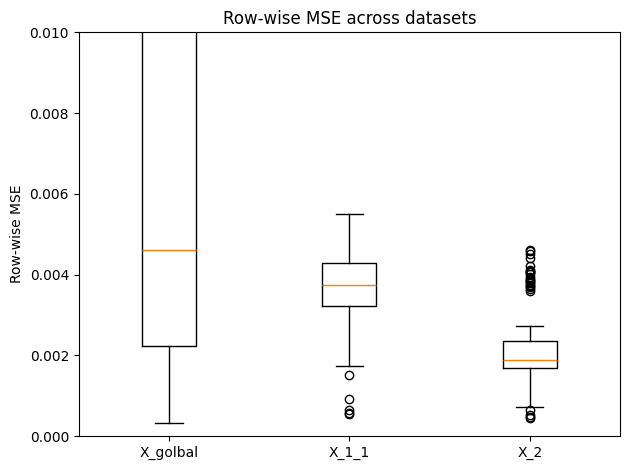

In [15]:
plt.figure()
# plt.boxplot([mse_test, mse_1_1, mse_1_5, mse_2], vert=True,
#             labels=["X_golbal", "X_1_1", "X_1_5", "X_2"])
plt.boxplot([mse_test, mse_1_1, mse_2], vert=True,
            labels=["X_golbal", "X_1_1", "X_2"])
plt.ylabel("Row-wise MSE")
plt.title("Row-wise MSE across datasets")
plt.ylim(0, 0.01)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3328129/658588102.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(regions, vert=True, labels=labels)


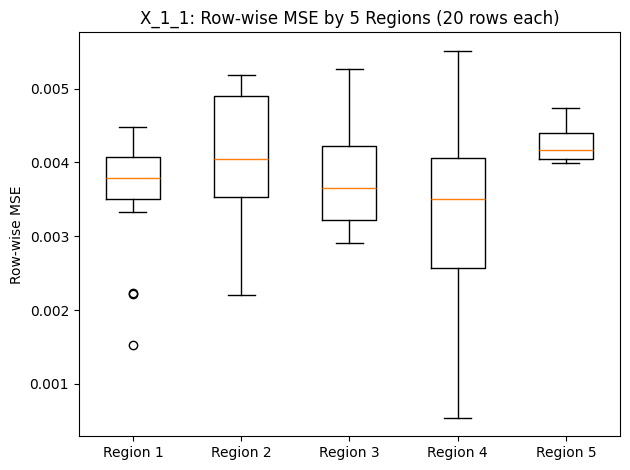

In [13]:
region_size = 20
regions = []
labels = []
for i in range(5):
    start = i * region_size
    end   = (i + 1) * region_size
    regions.append(mse_1_1[start:end])
    labels.append(f"Region {i+1}")


plt.figure()
plt.boxplot(regions, vert=True, labels=labels)
plt.ylabel("Row-wise MSE")
plt.title("X_1_1: Row-wise MSE by 5 Regions (20 rows each)")
plt.tight_layout()
plt.show()

# KNN Dist

In [6]:
from sklearn.neighbors import NearestNeighbors

# X_train = pd.read_csv("../Data/X_train.csv").values
X_train = pd.read_csv('../Data/Data20260110/X_train_Final_10.csv', header=None, delimiter=',').values
# X_train = X_train[:4096, :]
X_test = pd.read_csv('../Data/Data20260110/X_test.csv', header=None, delimiter=',').values
X_MI_1_5   = pd.read_csv("X_MI_1_5.csv").values
X_MI_2     = pd.read_csv("X_MI_2.csv").values
X_MI_3 = pd.read_csv("X_MI_3.csv").values
X_HCM = pd.read_csv("X_HCM.csv").values



k = 100
nn = NearestNeighbors(n_neighbors=k, metric="euclidean", algorithm="auto")
nn.fit(X_train)

def mean_knn_dist(X_query, model, k):

    distances, indices = model.kneighbors(X_query, n_neighbors=k, return_distance=True)
    mean_dist = distances.mean(axis=1)
    return mean_dist


mean_dist_test = mean_knn_dist(X_test, nn, k)

mean_dist_MI_1_5 = mean_knn_dist(X_MI_1_5, nn, k)
mean_dist_MI_2 = mean_knn_dist(X_MI_2, nn, k)
mean_dist_MI_3 = mean_knn_dist(X_MI_3, nn, k)

mean_dist_HCM = mean_knn_dist(X_HCM, nn, k)



C:\Users\r4718\AppData\Local\Temp\ipykernel_14360\1637186909.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


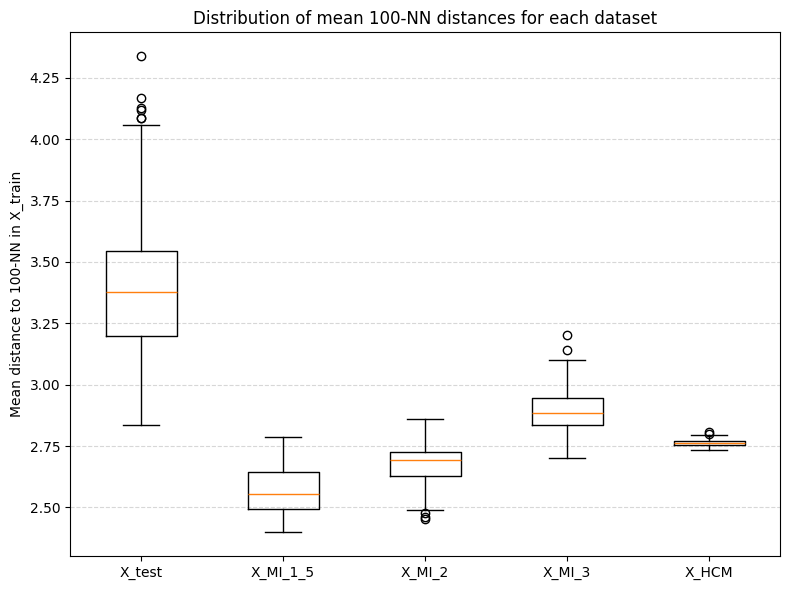

In [7]:
import matplotlib.pyplot as plt


data = [mean_dist_test, mean_dist_MI_1_5, mean_dist_MI_2, mean_dist_MI_3, mean_dist_HCM]
labels = ["X_test", "X_MI_1_5", "X_MI_2", "X_MI_3", "X_HCM"]

plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    labels=labels,

)

plt.ylabel("Mean distance to 100-NN in X_train")
plt.title("Distribution of mean 100-NN distances for each dataset")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()